# Advanced Chromatographic Processes - Exercises

## Exercise 1: Modelling dispersion of valves and tubing

Take the example from the lesson and add tubing using a `TubularReactor` with $L_c = 0.5~m$, $A_c = 1 \cdot 10^{-5}~m^2$, and $D_{ax} = 1 \cdot 10^{-5}~m^2 \cdot s^{-1}$.

***Task:*** Plot the inlet and outlet of every unit operation and compare the results to a system without any considerations for valving and tubing.

In [1]:
Q = 1e-6/60

from CADETProcess.processModel import ComponentSystem
from CADETProcess.processModel import Langmuir
from CADETProcess.processModel import (
    Inlet, Cstr, TubularReactor, LumpedRateModelWithPores, Outlet
)
from CADETProcess.processModel import FlowSheet
from CADETProcess.processModel import Process

# Component System
component_system = ComponentSystem(['A', 'B'])

# Binding Model
binding_model = Langmuir(component_system, name='langmuir')
binding_model.is_kinetic = False
binding_model.adsorption_rate = [0.02, 0.03]
binding_model.desorption_rate = [1, 1]
binding_model.capacity = [100, 100]

# Unit Operations
feed = Inlet(component_system, name='feed')
feed.c = [10, 10]

eluent = Inlet(component_system, name='eluent')
eluent.c = [0, 0]

# Mixer
valve = Cstr(component_system, 'valve')
valve.V = 1e-6
valve.flow_rate = Q

# Tubing
tubing = TubularReactor(component_system, 'tubing')
tubing.length = 0.5
tubing.cross_section_area = 1e-5
tubing.axial_dispersion = 1e-5

# Column
column = LumpedRateModelWithPores(component_system, 'column')
column.binding_model = binding_model
column.length = 0.1
column.diameter = 0.01
column.bed_porosity = 0.37
column.particle_radius = 4.5e-5
column.particle_porosity = 0.33
column.axial_dispersion = 2.0e-7
column.film_diffusion = [1e-4, 1e-4]

outlet = Outlet(component_system, name='outlet')

# Flow Sheet
flow_sheet = FlowSheet(component_system)

flow_sheet.add_unit(feed)
flow_sheet.add_unit(eluent)
flow_sheet.add_unit(valve)
flow_sheet.add_unit(tubing)
flow_sheet.add_unit(column)
flow_sheet.add_unit(outlet)

flow_sheet.add_connection(feed, valve)
flow_sheet.add_connection(eluent, valve)
flow_sheet.add_connection(valve, tubing)
flow_sheet.add_connection(tubing, column)
flow_sheet.add_connection(column, outlet)

# Process
process = Process(flow_sheet, 'batch elution')

## Create Events and Durations
process.add_event('feed_on', 'flow_sheet.feed.flow_rate', Q, 0)
process.add_event('feed_off', 'flow_sheet.feed.flow_rate', 0.0, 60)

process.add_event('eluent_off', 'flow_sheet.eluent.flow_rate', 0.0, 0)
process.add_event('eluent_on', 'flow_sheet.eluent.flow_rate', Q, 60)

## Set Process Times
process.cycle_time = 1200

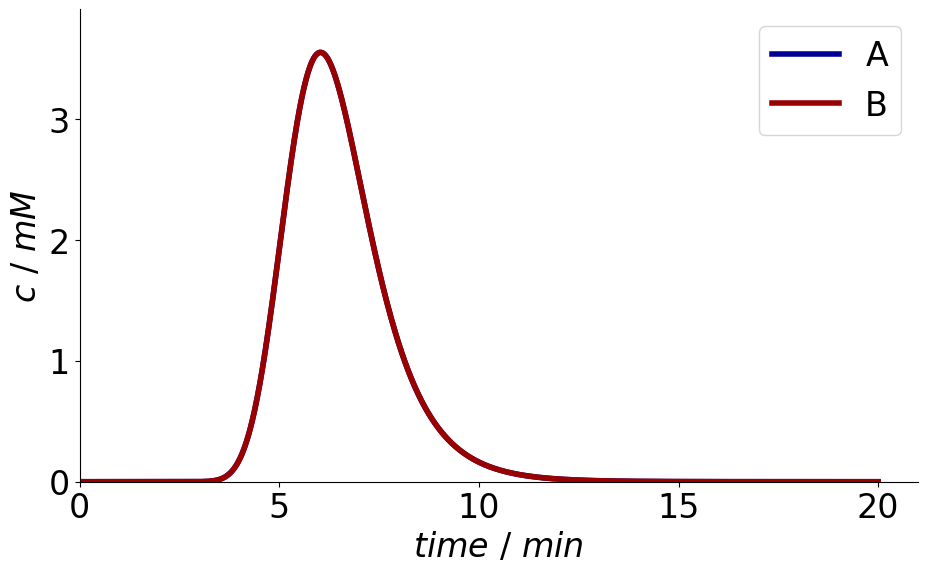

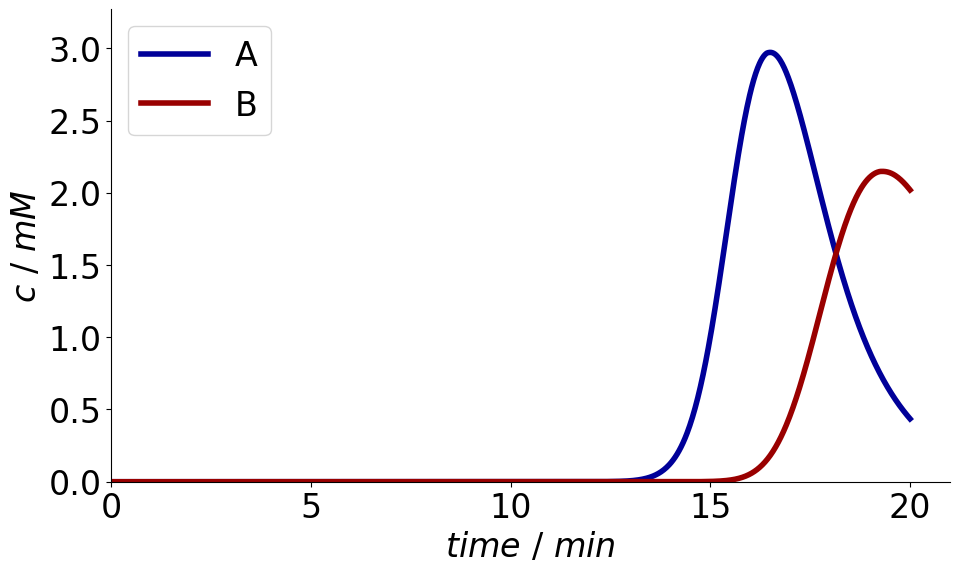

In [2]:
from CADETProcess.simulator import Cadet
process_simulator = Cadet()

simulation_results = process_simulator.simulate(process)
_ = simulation_results.solution.column.inlet.plot()
_ = simulation_results.solution.column.outlet.plot()

In [3]:
n_comp = 2
t_inj = 20
t_cycle = 3600
t_wash = 3600
n_cycles = 4

clr_model = get_clr_template()

## Sections and Connections
clr_model.root.input.solver.sections.nsec = 3
clr_model.root.input.solver.sections.section_times = [0.0, t_inj, (n_cycles)*t_cycle, n_cycles*t_cycle+t_wash]
clr_model.root.input.solver.sections.section_continuity = [0,0]

## Inlet Profile
clr_model.root.input.model.unit_000.sec_000.const_coeff = n_comp*[1.0,]
clr_model.root.input.model.unit_000.sec_001.const_coeff = n_comp*[0.0,]
clr_model.root.input.model.unit_000.sec_002.const_coeff = n_comp*[0.0,]

## Switches
clr_model.root.input.model.connections.nswitches = 3
clr_model.root.input.model.connections.switch_000.section = 0
clr_model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, 2.88e-8,
    1, 2, -1, -1, 2.88e-8,
]
clr_model.root.input.model.connections.switch_001.section = 1
clr_model.root.input.model.connections.switch_001.connections = [
    1, 1, -1, -1, 2.88e-8,
]
clr_model.root.input.model.connections.switch_002.section = 2
clr_model.root.input.model.connections.switch_002.connections = [
    0, 1, -1, -1, 2.88e-8,
    1, 2, -1, -1, 2.88e-8,
]

# set the times that the simulator writes out data for
clr_model.root.input.solver.user_solution_times = np.linspace(0, n_cycles*t_cycle+t_wash, 601)

run_simulation(clr_model)

time = clr_model.root.output.solution.solution_times
c = clr_model.root.output.solution.unit_001.solution_outlet

plt.plot(time, c)

NameError: name 'get_clr_template' is not defined

## Example 2: Carousel System

Consider the following multi column system:

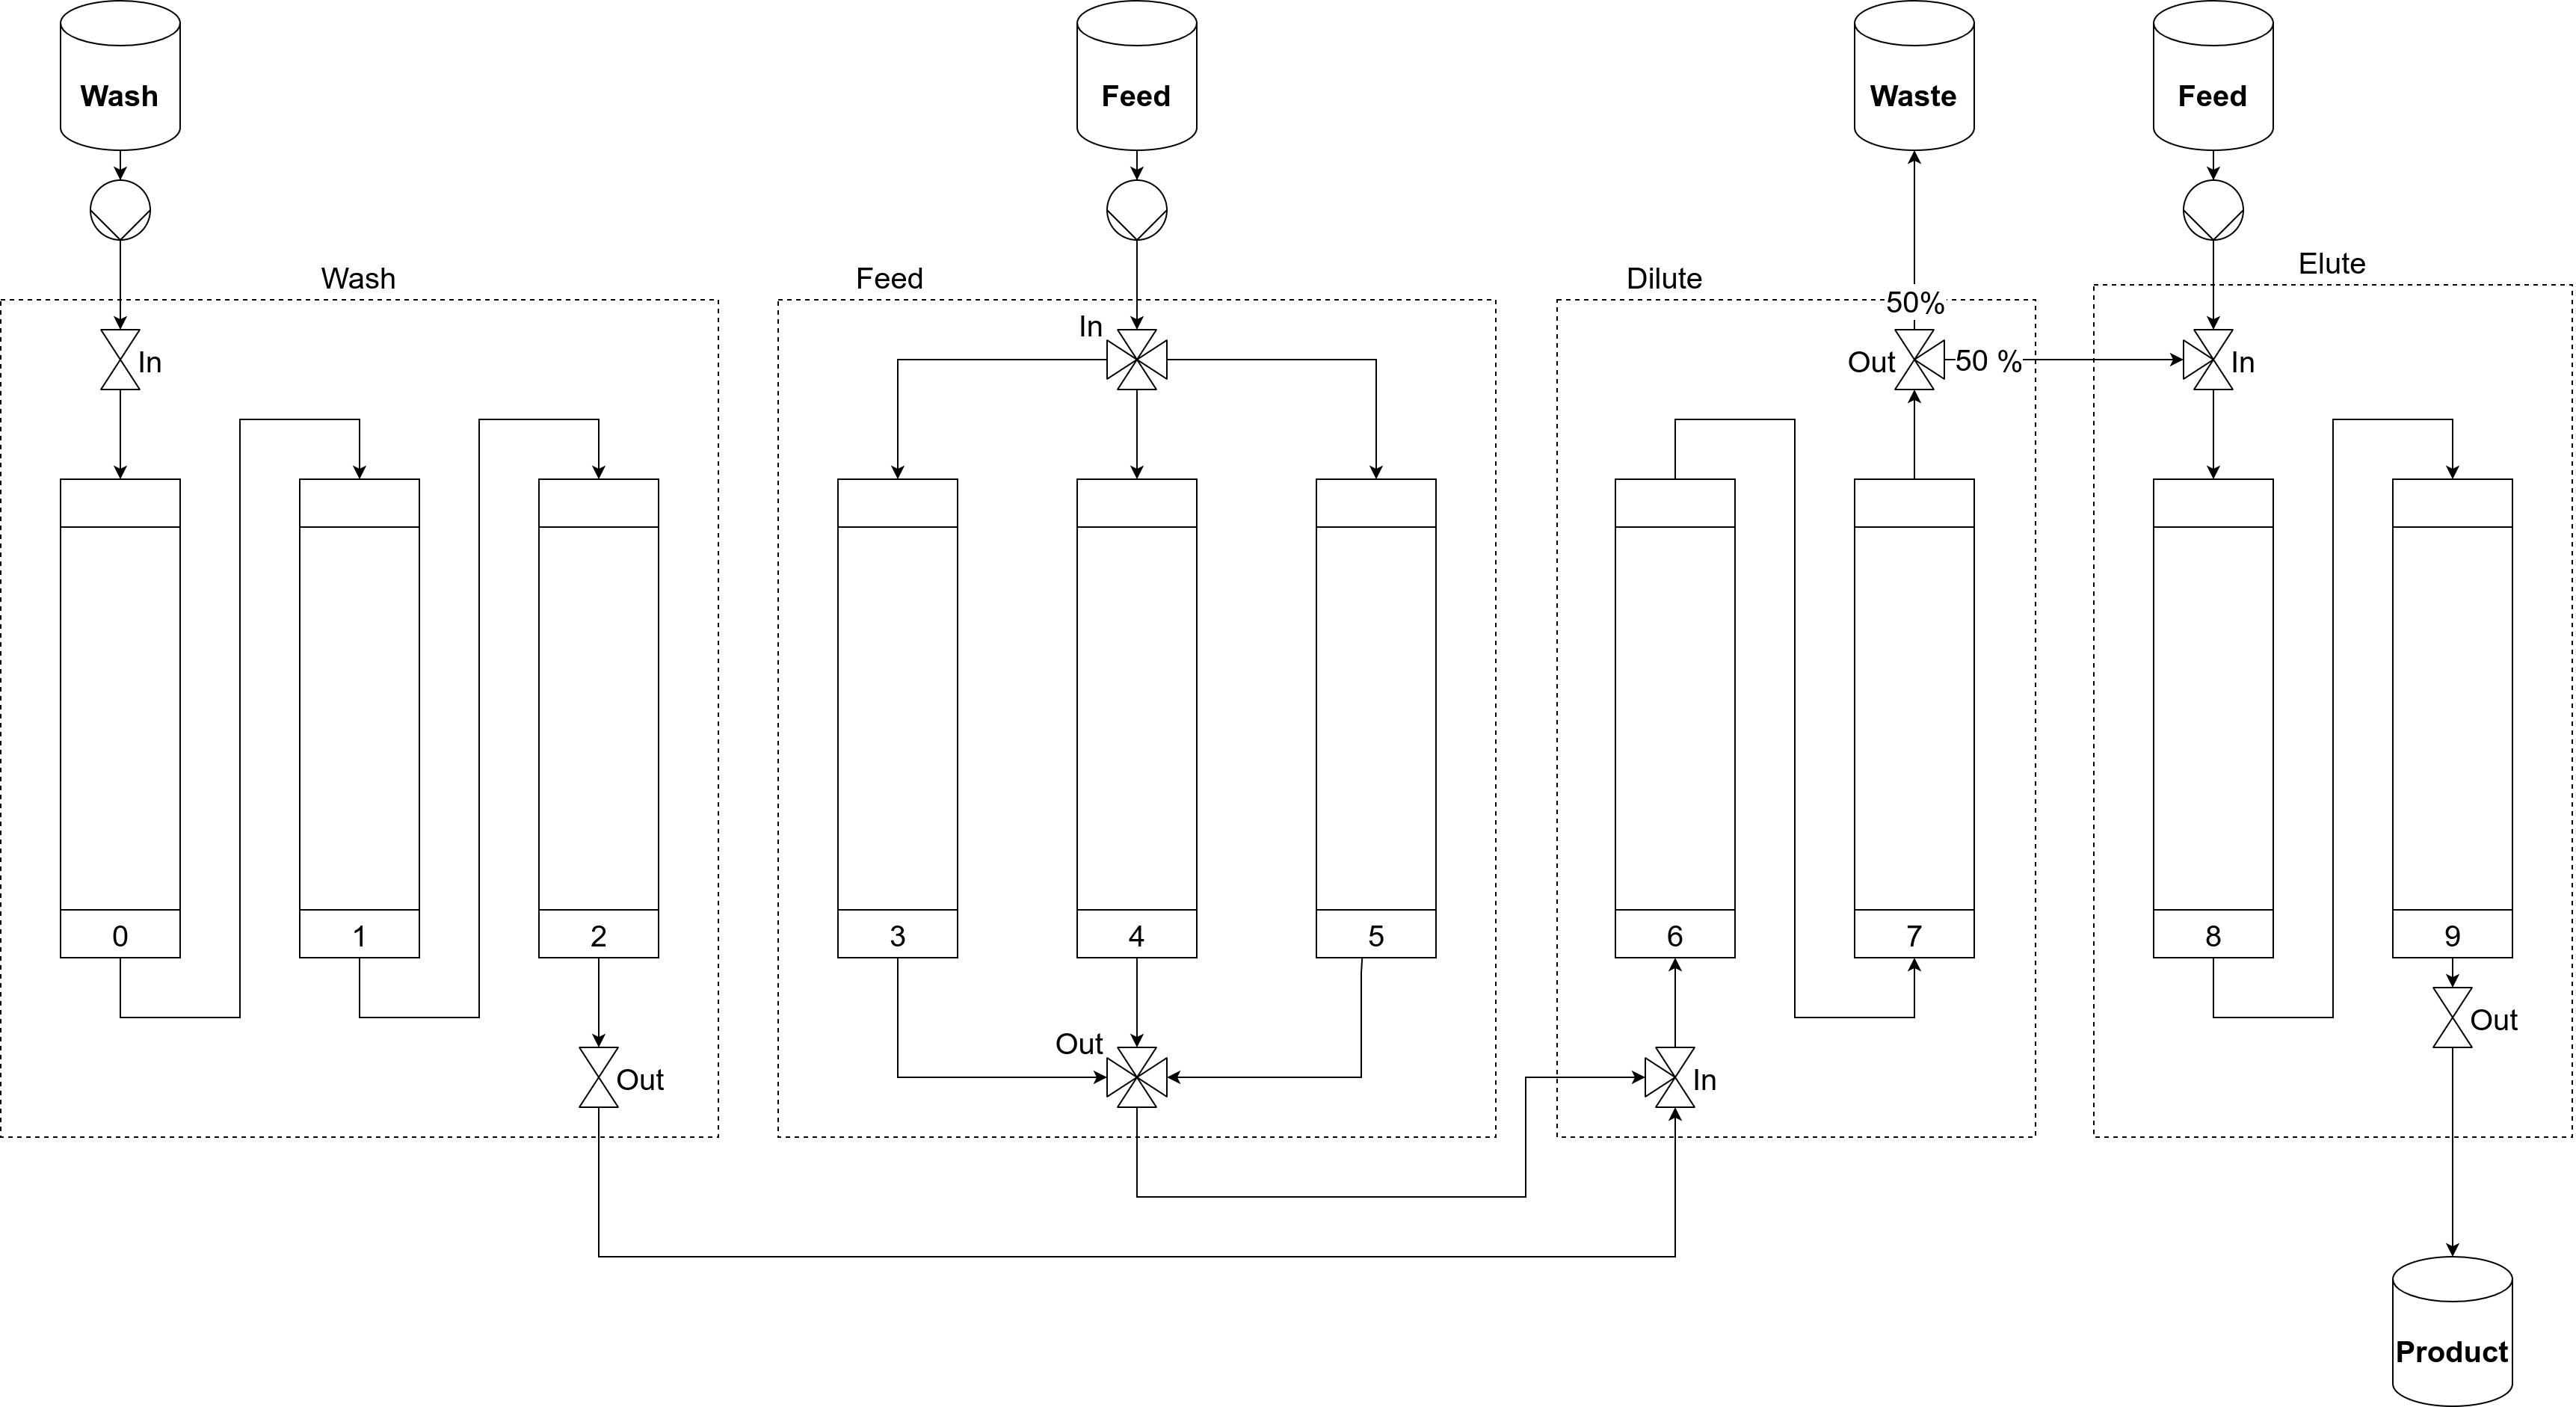

There exist four zones in this system:
- Wash: 3 columns in series
- Feed: 3 columns in parallel
- Dilute: 2 columns in series; reverse flow
- Elute: 2 Columns in series

In [4]:
from CADETProcess.processModel import Inlet, Outlet
i_wash = Inlet(component_system, name='i_wash')
i_wash.c = [0, 0]
i_wash.flow_rate = 60/60/1e6
i_feed = Inlet(component_system, name='i_feed')
i_feed.c = [10, 10]
i_feed.flow_rate = 30/60/1e6
i_elute = Inlet(component_system, name='i_elute')
i_elute.c = [0, 0]
i_elute.flow_rate = 60/60/1e6

o_waste = Outlet(component_system, name='o_waste')
o_product = Outlet(component_system, name='o_product')

Now the zones are set up and the reverse flow is set in the dilution zone.

In [5]:
from CADETProcess.modelBuilder import SerialZone, ParallelZone

z_wash = SerialZone(component_system, 'z_wash', 3)
z_feed = ParallelZone(component_system, 'z_feed', 3)
z_dilute = SerialZone(component_system, 'z_dilute', 2, flow_direction=-1)
z_elute = SerialZone(component_system, 'z_elute', 2)


As in the previous example, the units and zones are added and connected in the CarouselBuilder

In [6]:
from CADETProcess.modelBuilder import CarouselBuilder
        
builder = CarouselBuilder(component_system, 'multi_zone')
builder.column = column
builder.add_unit(i_wash)
builder.add_unit(i_feed)
builder.add_unit(i_elute)

builder.add_unit(o_waste)
builder.add_unit(o_product)

builder.add_unit(z_wash)
builder.add_unit(z_feed)
builder.add_unit(z_dilute)
builder.add_unit(z_elute)

builder.add_connection(i_wash, z_wash)
builder.add_connection(z_wash, z_dilute)
builder.add_connection(i_feed, z_feed)
builder.add_connection(z_feed, z_dilute)
builder.add_connection(z_dilute, o_waste)
builder.add_connection(z_dilute, z_elute)
builder.set_output_state(z_dilute, [0.5, 0.5])
builder.add_connection(i_elute, z_elute)
builder.add_connection(z_elute, o_product)